# Test

Import usefull packages + the njord library. For installations details please refer to README file. 

In [6]:
import njord as nj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hyper parameters

In [60]:
# Dataset parameters.
PATH = "dataset"
SYMBOL = "btcusdt"
DATASET = "ohlc"
PERIOD = 600
FILENAME_TR = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "train")
FILENAME_TE = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "test")

# Batch parameters.
LOOKBACK = 16
LOOKAHEAD = 1
TARGET = "close"

# Training parameters.
LR = 0.0001
EPOCHS = 100
MINIBATCH_SIZE = 128

## Dataset

Load the dataset from .csv file to a pandas dataframe.

In [61]:
# Load the training dataset.
data_tr = pd.read_csv(PATH + "/" + FILENAME_TR)
data_tr = data_tr.set_index("time")
data_tr.index = pd.to_datetime(data_tr.index)

# Load the test dataset.
data_te = pd.read_csv(PATH + "/" + FILENAME_TE)
data_te = data_te.set_index("time")
data_te.index = pd.to_datetime(data_te.index)

In [62]:
# Display the number of samples for the datasets.
print("Number of samples train = {}".format(data_tr.shape))
print("Number of samples test = {}".format(data_te.shape))

# Display the head of the dataset.
print("\n3. training head: \n{}".format(data_tr.head()))
print("\n3. test head: \n{}".format(data_te.head()))

Number of samples train = (8784, 5)
Number of samples test = (2736, 5)

3. training head: 
                        open     high      low    close          avg
time                                                                
2018-09-01 00:10:00  7011.21  7044.35  7010.00  7041.65  7029.350052
2018-09-01 00:20:00  7041.87  7041.87  7031.82  7038.41  7037.445636
2018-09-01 00:30:00  7038.41  7046.00  7034.72  7046.00  7041.031830
2018-09-01 00:40:00  7046.00  7049.00  7036.28  7043.81  7044.063838
2018-09-01 00:50:00  7045.42  7046.33  7030.05  7030.05  7038.251102

3. test head: 
                        open     high      low    close          avg
time                                                                
2018-11-01 00:10:00  6371.93  6376.99  6369.57  6375.15  6374.240114
2018-11-01 00:20:00  6375.19  6376.98  6372.19  6374.48  6374.350265
2018-11-01 00:30:00  6373.21  6375.00  6360.77  6366.25  6368.364441
2018-11-01 00:40:00  6366.56  6366.80  6355.00  6355.17  6361.868

## Batch and data normalisation

We now have to build the batch, i.e. a feature array X with its associated targets Y. 

- The timeseries X are normalise with the pivot method.

- The targets are casted:
    1. Y > 0 = 1, rise
    2. Y < 0 = 0, drop

In [63]:
# Load the training and test batch.
batch_tr = nj.Batch(data_tr, LOOKBACK, LOOKAHEAD)
batch_te = nj.Batch(data_te, LOOKBACK, LOOKAHEAD)

# Build the training and test batch to get the features and the targets.
X_tr, Y_tr = batch_tr.build(target="avg", method="pvt")
X_te, Y_te = batch_te.build(target="avg", method="pvt")

# Cast the targets.
Y_tr = 1.0 * ( Y_tr > 0.0 ).reshape(-1,1)
Y_te = 1.0 * ( Y_te > 0.0 ).reshape(-1,1)

In [64]:
# Display features information.
print("\nTraining Features info:")
print("X_tr shape = {}".format(X_tr.shape))
print("X_tr mean  = {}".format(X_tr.mean()))
print("X_tr std   = {}".format(X_tr.std()))
print("\nTest Features info:")
print("X_te shape = {}".format(X_te.shape))
print("X_te mean  = {}".format(X_te.mean()))
print("X_te std   = {}".format(X_te.std()))


Training Features info:
X_tr shape = (8751, 16, 5)
X_tr mean  = 0.010660262377854819
X_tr std   = 0.5791731304359717

Test Features info:
X_te shape = (2669, 16, 5)
X_te mean  = 0.07223071167349669
X_te std   = 0.5865227771674386


In [65]:
# Display targets information.
print("\nTraining Targets info:")
print("Y_tr shape = {}".format(Y_tr.shape))
print("Y_tr mean  = {}".format(Y_tr.mean()))
print("Y_tr std   = {}".format(Y_tr.std()))
print("Y_tr samples = \n{}".format(Y_tr[0:10,0]))
print("\nTest Targets info:")
print("Y_te shape = {}".format(Y_te.shape))
print("Y_te mean  = {}".format(Y_te.mean()))
print("Y_te std   = {}".format(Y_te.std()))
print("Y_te samples = \n{}".format(Y_te[0:10,0]))


Training Targets info:
Y_tr shape = (8751, 1)
Y_tr mean  = 0.5069134956005028
Y_tr std   = 0.4999522012938655
Y_tr samples = 
[0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]

Test Targets info:
Y_te shape = (2669, 1)
Y_te mean  = 0.49044585987261147
Y_te std   = 0.4999087100725754
Y_te samples = 
[1. 1. 0. 0. 1. 1. 1. 0. 0. 1.]


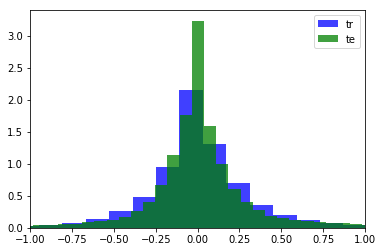

In [66]:
# Histogram: Train and test Features.
hist_X_tr = plt.hist(X_tr.reshape(-1, 1), 200, density=True, facecolor="b", alpha=0.75, label="tr")
hist_X_te = plt.hist(X_te.reshape(-1, 1), 200, density=True, facecolor="g", alpha=0.75, label="te")
plt.xlim([-1, 1])
plt.legend()
plt.show()

Number of drops tr = 4315
Number of rises tr = 4436
Number of drops te = 1360
Number of rises te = 1309


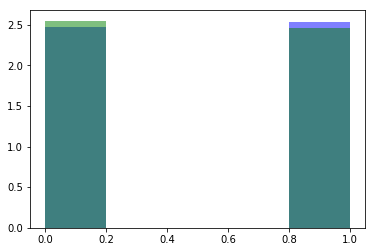

In [67]:
# Histogram: Targets.
histY = plt.hist(Y_tr, 5, density=True, facecolor="b", alpha=0.50)
histY = plt.hist(Y_te, 5, density=True, facecolor="g", alpha=0.50)

# Evalute the number of rise and drops for the training set.
print("Number of drops tr = {}".format(np.sum(Y_tr == 0)))
print("Number of rises tr = {}".format(np.sum(Y_tr == 1)))

# Evaluate the number of rise and drops for the test set.
print("Number of drops te = {}".format(np.sum(Y_te == 0)))
print("Number of rises te = {}".format(np.sum(Y_te == 1)))

## Training

Train a model with keras.

In [68]:
# Import usefull packages.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
import keras.backend as K

In [69]:
# Define the precision.
def P(y_true, y_pred):
    """Function that computes the precision.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Define the recall.
def R(y_true, y_pred):
    """Function that computes the recall.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
# Reshape the training dataset.
X_train = X_tr.reshape(X_tr.shape[0], -1)
Y_train = Y_tr.reshape(X_tr.shape[0], -1)

# Reshape the test dataset.
X_test = X_te.reshape(X_te.shape[0], -1)
Y_test = Y_te.reshape(X_te.shape[0], -1)

# Build the model.
model = Sequential()
model.add(Dense(units=128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))

# Set the optimizer.
optimizer = optimizers.RMSprop(lr=LR, rho=0.95, epsilon=1.0E-6, decay=0.0)

# Compile the model.
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[R, P])

# Set the training parameters.
params = {
    "epochs": EPOCHS,
    "batch_size": MINIBATCH_SIZE,
    "validation_data": (X_test, Y_test),
    "verbose": 2
}

# Train the model.
history = model.fit(X_train, Y_train, **params)

# Training finished.
print("Training finished")

Train on 8751 samples, validate on 2669 samples
Epoch 1/100
 - 1s - loss: 0.6996 - R: 0.5585 - P: 0.5157 - val_loss: 0.6895 - val_R: 0.6090 - val_P: 0.5621
Epoch 2/100
 - 0s - loss: 0.6977 - R: 0.5597 - P: 0.5335 - val_loss: 0.6852 - val_R: 0.6072 - val_P: 0.6080
Epoch 3/100
 - 0s - loss: 0.6926 - R: 0.5882 - P: 0.5507 - val_loss: 0.6822 - val_R: 0.7063 - val_P: 0.6123
Epoch 4/100
 - 0s - loss: 0.6884 - R: 0.6200 - P: 0.5677 - val_loss: 0.6782 - val_R: 0.6545 - val_P: 0.6273
Epoch 5/100
 - 0s - loss: 0.6831 - R: 0.6250 - P: 0.5810 - val_loss: 0.6730 - val_R: 0.6678 - val_P: 0.6397
Epoch 6/100
 - 0s - loss: 0.6813 - R: 0.6637 - P: 0.6011 - val_loss: 0.6656 - val_R: 0.6775 - val_P: 0.6576
Epoch 7/100
 - 0s - loss: 0.6740 - R: 0.6479 - P: 0.6081 - val_loss: 0.6584 - val_R: 0.6932 - val_P: 0.6566
Epoch 8/100
 - 0s - loss: 0.6682 - R: 0.6775 - P: 0.6248 - val_loss: 0.6504 - val_R: 0.7100 - val_P: 0.6560
Epoch 9/100
 - 0s - loss: 0.6597 - R: 0.6993 - P: 0.6345 - val_loss: 0.6431 - val_R: 0.7

Epoch 76/100
 - 0s - loss: 0.5506 - R: 0.7293 - P: 0.7253 - val_loss: 0.5418 - val_R: 0.7331 - val_P: 0.6945
Epoch 77/100
 - 0s - loss: 0.5489 - R: 0.7283 - P: 0.7270 - val_loss: 0.5415 - val_R: 0.7371 - val_P: 0.6934
Epoch 78/100
 - 0s - loss: 0.5472 - R: 0.7358 - P: 0.7257 - val_loss: 0.5422 - val_R: 0.7406 - val_P: 0.6947
Epoch 79/100
 - 0s - loss: 0.5458 - R: 0.7299 - P: 0.7266 - val_loss: 0.5420 - val_R: 0.7428 - val_P: 0.6918
Epoch 80/100
 - 0s - loss: 0.5468 - R: 0.7409 - P: 0.7219 - val_loss: 0.5410 - val_R: 0.7342 - val_P: 0.6962
Epoch 81/100
 - 0s - loss: 0.5487 - R: 0.7221 - P: 0.7226 - val_loss: 0.5412 - val_R: 0.7405 - val_P: 0.6942
Epoch 82/100
 - 0s - loss: 0.5496 - R: 0.7359 - P: 0.7256 - val_loss: 0.5405 - val_R: 0.7337 - val_P: 0.6951
Epoch 83/100
 - 0s - loss: 0.5483 - R: 0.7412 - P: 0.7184 - val_loss: 0.5409 - val_R: 0.7365 - val_P: 0.7073
Epoch 84/100
 - 0s - loss: 0.5453 - R: 0.7326 - P: 0.7271 - val_loss: 0.5404 - val_R: 0.7339 - val_P: 0.6937


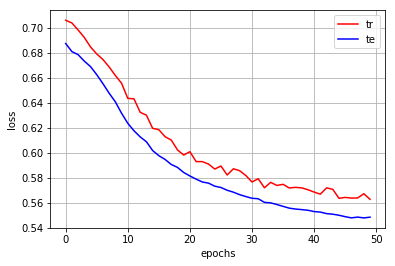

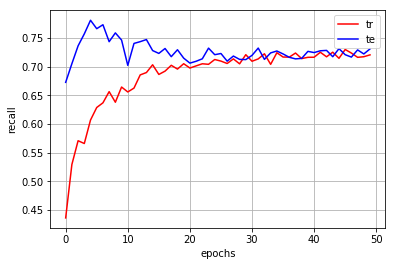

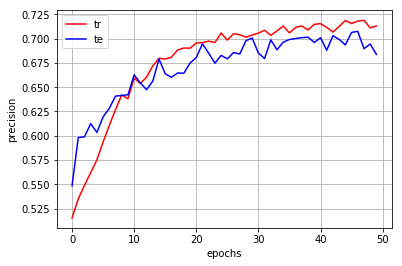

In [59]:
# Figure: loss vs epochs.
plt.figure()
plt.plot(history.history["loss"], label="tr", color="r")
plt.plot(history.history["val_loss"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

# Figure: recall vs. epochs.
plt.figure()
plt.plot(history.history["R"], label="tr", color="r")
plt.plot(history.history["val_R"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()
plt.grid()
plt.show()

# Figure: precision vs. epochs.
plt.figure()
plt.plot(history.history["P"], label="tr", color="r")
plt.plot(history.history["val_P"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()
plt.grid()
plt.show()

In [44]:
# Evaluate the model on th train set.
eval_tr = model.evaluate(X_train, Y_train, verbose=2)

# Evaluate the model on th test set.
eval_te = model.evaluate(X_test, Y_test, verbose=2)

# Display the results.
print("Evaluate model on the training set: \n {}".format(eval_tr))
print("Evaluate model on the test set:     \n {}".format(eval_te))

Evaluate model on the training set: 
 [0.5348431635224442, 0.7704696973593981, 0.7182909884210069]
Evaluate model on the test set:     
 [0.550140203083888, 0.7638393901134976, 0.680267000966592]
